In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from joblib import dump, load
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
model = load('./models/predict_oxygen_model.joblib')

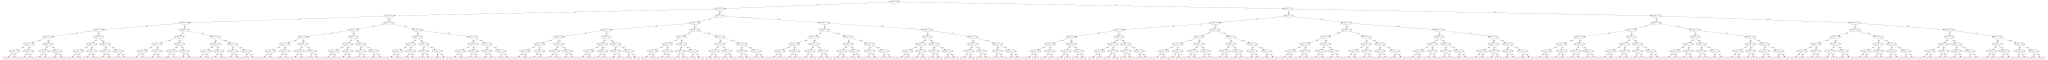

In [3]:
model.plot_tree(0)

In [4]:
data = pd.read_csv('data/data_new.csv')

In [5]:
data = data[data['state'] == 'movement']

In [6]:
data = data.drop('data_time', axis=1)

In [7]:
data = data.drop(['values_state_speed', 'values_state_frequency', 'values_state_vibration', 'values_state_left_bak', 'values_state_right_bak', 'state', 'state_boat'], axis=1)

In [8]:
data

,values_speed,values_frequency,values_vibration,values_left_bak,values_right_bak
0,0.4,0.00000,0.000000,0.0000,0.0000
112,6.6,12530.55267,25.901055,5740.0290,5748.7325
113,6.6,12530.55267,25.901055,5740.0290,5748.8145
114,6.6,12530.55267,25.901055,5740.0290,5748.7885
115,6.6,12530.55267,25.901055,5740.0290,5748.7605
...,...,...,...,...,...
15065,0.6,0.00000,0.000000,6171.9278,6082.7148
15066,0.6,0.00000,0.000000,6171.9278,6082.6988
15067,0.6,0.00000,0.000000,6171.9038,6082.7348
15068,0.6,0.00000,0.000000,6171.9038,6082.7148


In [9]:
data = data.drop('data_time', axis=1)

{'frequency_predict': 811.5853514865498,
 'left_bak_predict': 5748.554062529955,
 'right_bak_predict': 5751.193048767978,
 'speed_predict': 2.6327826199267146,
 'vibration_predict': 21.89787389873237}

In [10]:
data = data.drop(['values_state_speed', 'values_state_frequency', 'values_state_vibration', 'values_state_left_bak', 'values_state_right_bak', 'state', 'state_boat'], axis=1)

In [11]:
data

In [12]:
{
    "frequency_predict": 811.5853514865498,
    "left_bak_predict": 5748.554062529955,
    "right_bak_predict": 5751.193048767978,
    "speed_predict": 2.6327826199267146,
    "vibration_predict": 21.89787389873237
}

In [13]:
def lag_preprocess(df, name):
    
    # смещение
    for i in range(30, 0, -1):
        oxy_shift = df[f'{name}'].shift(periods=i)
        oxy_shift.name = f'{name} {i} shift'
        df[oxy_shift.name] = oxy_shift
    return df

In [14]:
values_speed = data.copy(deep=True)
values_frequency = data.copy(deep=True)
values_vibration = data.copy(deep=True)
values_left_bak = data.copy(deep=True)
values_right_bak = data.copy(deep=True)

In [15]:
values_speed = lag_preprocess(values_speed, 'values_speed')
values_frequency = lag_preprocess(values_frequency, 'values_frequency')
values_vibration = lag_preprocess(values_vibration, 'values_vibration')
values_left_bak = lag_preprocess(values_left_bak, 'values_left_bak')
values_right_bak = lag_preprocess(values_right_bak, 'values_right_bak')

In [16]:
cat_params = {
    'iterations': 100,
    'learning_rate': 0.05,
    'l2_leaf_reg': 2.0,
    'loss_function': 'RMSE',
    'random_state': 2022,
    'use_best_model': True,
    'eval_metric': 'RMSE',
    'depth': 8,
    'silent': True,
}
model = CatBoostRegressor(**cat_params)

((4536, 34), (4536,))

In [17]:
values_speed = values_speed.tail(values_speed.shape[0] - 30)
values_frequency = values_frequency.tail(values_frequency.shape[0] - 30)
values_vibration = values_vibration.tail(values_vibration.shape[0] - 30)
values_left_bak = values_left_bak.tail(values_left_bak.shape[0] - 30)
values_right_bak = values_right_bak.tail(values_right_bak.shape[0] - 30)

In [18]:
X = values_right_bak.drop('values_right_bak', axis=1)
y = values_right_bak['values_right_bak']
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

TRAIN:
 0.9928127772798145 

TEST:
 0.9934369164235433 



In [19]:
X.shape, y.shape

['models/vodnik_predict_values_right_bak_model.joblib']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=2022)
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_test, y_test)
model.fit(train_pool, eval_set=valid_pool)

In [19]:
print('TRAIN:\n', model.score(X_train, y_train), '\n')
print('TEST:\n', model.score(X_test, y_test), '\n')

In [19]:
dump(model, 'models/vodnik_predict_values_right_bak_model.joblib')

KeyError: 'temperature'

In [ ]:
# смещение
for i in range(30, 0, -1):
    oxy_shift = data['temperature'].shift(periods=i)
    oxy_shift.name = f'temp {i} shift'
    data[oxy_shift.name] = oxy_shift

In [ ]:
data = data.drop('date', axis=1)

In [ ]:
data = data.tail(data.shape[0] - 30)
test = data.tail(30)
data = data.head(data.shape[0] - 30)

In [ ]:
X = data.drop(['vibro', 'oxygen', 'temperature'], axis=1)
y = data['temperature']
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [ ]:
X.shape, y.shape

In [ ]:
cat_params = {
    'iterations': 100,
    'learning_rate': 0.05,
    'l2_leaf_reg': 2.0,
    'loss_function': 'RMSE',
    'random_state': 2022,
    'use_best_model': True,
    'eval_metric': 'RMSE',
    'depth': 8,
}

In [ ]:
model = CatBoostRegressor(**cat_params)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=2022)

In [ ]:
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_test, y_test)

In [ ]:
model.fit(train_pool, eval_set=valid_pool)

In [ ]:
print('TRAIN:\n', model.score(X_train, y_train), '\n')
print('TEST:\n', model.score(X_test, y_test), '\n')

In [ ]:
test = test.drop('vibro', axis=1)
test = np.asarray(test).astype(np.float32)

In [ ]:
predict = model.predict(test)

In [ ]:
asd = [i[2] for i in test]

In [ ]:
print(plt.plot(asd))
print(plt.plot(predict))

In [ ]:
dump(model, 'models/predict_temperature_model.joblib')

#### Future predict

In [ ]:
data = data.drop(['vibro', 'temperature'], axis=1)

In [ ]:
predicts = []

for i in range(0, 200, 1):
    #print(data.drop('oxygen', axis=1).iloc[[-1]].values)
    predict = model.predict(np.asarray(data.drop('oxygen', axis=1).iloc[[-1]].values).astype(np.float32))
    predicts.append(predict[0])
    series = []
    series.append(predict[0])
    for k in range(30, 0, -1):
        series.append(data.iloc[[-k]]['oxygen'].values[0])
    data = data.append(pd.Series(series, index=data.columns), ignore_index=True)

In [ ]:
asd = [i[2] for i in test]
print(plt.plot(asd))
print(plt.plot(predicts))

In [ ]:
data

In [ ]:
# смещение
for i in range(30, 0, -1):
    oxy_shift = data['temperature'].shift(periods=i)
    oxy_shift.name = f'Temp {i} shift'
    data[oxy_shift.name] = oxy_shift
data = data.drop('date', axis=1)
data = data.tail(data.shape[0] - 30)
test = data.tail(30)
data = data.head(data.shape[0] - 30)
X = data.drop(['vibro', 'oxygen', 'temperature'], axis=1)
y = data['temperature']
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [ ]:
cat_params = {
    'iterations': 100,
    'learning_rate': 0.05,
    'l2_leaf_reg': 2.0,
    'loss_function': 'RMSE',
    'random_state': 2022,
    'use_best_model': True,
    'eval_metric': 'RMSE',
    'depth': 8,
}
model = CatBoostRegressor(**cat_params)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=2022)
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_test, y_test)
model.fit(train_pool, eval_set=valid_pool)

In [200]:
print('TRAIN:\n\n', model.score(X_train, y_train), '\n\n')
print('TEST:\n\n', model.score(X_test, y_test), '\n\n')

TRAIN:

 0.9924857717934141 


TEST:

 0.9868378943345159 




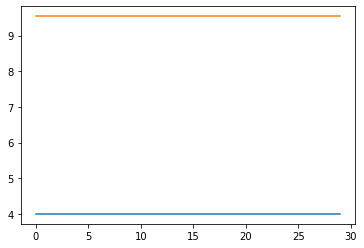

In [201]:
test = test.drop('temperature', axis=1)
test = np.asarray(test).astype(np.float32)
predict = model.predict(test)
asd = [i[2] for i in test]
print(plt.plot(asd))
print(plt.plot(predict))